<a href="https://colab.research.google.com/github/stephyi/AdSmart_AB_Test/blob/master/AdSmart_ABTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color='#2F4F4F'>Defining the Question</font>

### a) Specifying the Data Analysis Question

* Main objective is to test whether the ads that the advertising company runs resulted in a significant lift in brand awareness using a light-weight questionnaire.

### b) Methods

* A/B testing
* Machine Learning

### c) Recording the Experimental Design

1. Data Analaysis
2. Univariate and Bivariate Analysis
3. A/B testing using hypothesis testing
 
  - H0:there is no difference in brand awareness between the exposed and control groups in the current case.
   
  - H1:there is a difference in brand awareness between the exposed and control groups in the current case.

4. Machine learning
* Three machine learning models will be used to predict whether a user responds yes or no. ie.
   * Logistic Regressin
   * Decision trees
   * XGBoost
* I'll also use M.L to identify important features for brand awareness.

### d) Data Relevance
* auction_id: the unique id of the online user who has been presented the BIO. In standard terminologies this is called an impression id. The user may see the BIO questionnaire but choose not to respond. In that case both the yes and no columns are zero.
* experiment: which group the user belongs to  control or exposed.
* date: the date in YYYY-MM-DD format
* hour: the hour of the day in HH format.
device_make: the name of the type of device the user has e.g. Samsung
* platform_os: the id of the OS the user has. 
* browser: the name of the browser the user uses to see the BIO questionnaire.
* yes: 1 if the user chooses the “Yes” radio button for the BIO questionnaire.
* no: 1 if the user chooses the “No” radio button for the BIO questionnaire.


## <font color='#2F4F4F'> Data Cleaning & Preparation</font>

In [ ]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math as mt
import numpy as np
import pandas as pd
from scipy.stats import norm

%matplotlib inline

# to display all columns
pd.set_option('display.max.columns', None)

# to display the entire contents of a cell
pd.set_option('display.max_colwidth', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# load and preview dataset
df = pd.read_csv('AdSmartABdata.csv')
df.sample(3)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
707,168da473-e2ff-4792-a423-27d015d2df64,control,2020-07-05,0,Generic Smartphone,6,Chrome Mobile,0,0
3509,71872e27-b15c-459b-8aed-44058b87509e,exposed,2020-07-09,18,Generic Smartphone,6,Chrome Mobile,0,0
2483,506d74e1-e2e4-40ac-ab1c-da19790a62aa,exposed,2020-07-10,16,LDN-L01,6,Chrome Mobile WebView,0,0


In [ ]:
# check dataset shape
df.shape

(8077, 9)

Our dataset has 8077 records and 9 variables.

In [ ]:
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


>> This shows a brief description of the numerical variables



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


>> From the above output,you can see the data type of each column.Also note that there are no missing values in our dataframe.


In [ ]:
# check for missing values
df.isna().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

>> Clearly,there are no missing values

In [ ]:
# preview variable datatypes
df.dtypes

auction_id     object
experiment     object
date           object
hour            int64
device_make    object
platform_os     int64
browser        object
yes             int64
no              int64
dtype: object

>> Categorical Variables
 * experiment
 * device_make
 * platform_os
 * browser
 
 >> Numerical variables
  * date
  * hour
  * yes
  * no

In [ ]:
# check for duplicates
df.duplicated().sum()

0

We will look at the unique values in each variable just to be safe.

In [ ]:
columns = df.columns

for col in columns:
    print("Variable:", col)
    print("Number of unique values:", df[col].nunique())
    print(df[col].unique())
    print()

Variable: auction_id
Number of unique values: 8077
['0008ef63-77a7-448b-bd1e-075f42c55e39'
 '000eabc5-17ce-4137-8efe-44734d914446'
 '0016d14a-ae18-4a02-a204-6ba53b52f2ed' ...
 'ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7'
 'ffeeed62-3f7c-4a6e-8ba7-95d303d40969'
 'fffbb9ff-568a-41a5-a0c3-6866592f80d8']

Variable: experiment
Number of unique values: 2
['exposed' 'control']

Variable: date
Number of unique values: 8
['2020-07-10' '2020-07-07' '2020-07-05' '2020-07-03' '2020-07-09'
 '2020-07-04' '2020-07-06' '2020-07-08']

Variable: hour
Number of unique values: 24
[ 8 10  2 15  5  0 14 13  6 16  7 20  4 17  1 19 18  3 23 12  9 11 21 22]

Variable: device_make
Number of unique values: 270
['Generic Smartphone' 'E5823' 'Samsung SM-A705FN' 'Samsung SM-G960F'
 'Samsung SM-G973F' 'iPhone' 'Samsung SM-G935F' 'HTC One' 'LG-$2'
 'Samsung SM-A202F' 'XT1032' 'COL-L29' 'Samsung SM-N960U1'
 'Samsung SM-A715F' 'Samsung SM-G930F' 'I3312' 'Samsung SM-G950F'
 'FIG-LX1' 'Samsung SM-G920F' 'MRD-LX1' 'Samsung SM-N

>>Now we have a brief overview of how our data looks like but let's make some visulizations to see distributions etc.

## <font color='#2F4F4F'> Univariate  And Bivariate Analysis</font>

**EXPERIMENT**




Text(0.5, 1.0, 'No of total users in groups for the experiment')

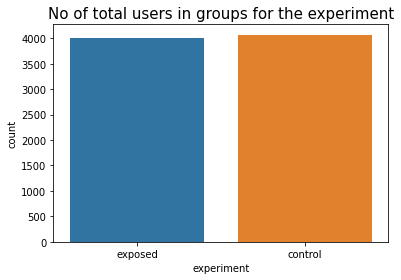

In [ ]:
sns.countplot(df['experiment'])
plt.title('No of total users in groups for the experiment',fontsize=15)

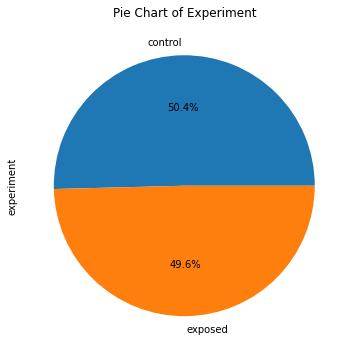

In [ ]:


plt.figure(figsize = (6, 6))
df.experiment.value_counts().plot(kind = 'pie', autopct = '%1.1f%%')
plt.title('Pie Chart of Experiment')
plt.show()

In [ ]:
df.experiment.value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

>> Distribution of numbers of users in exposed and control group are almost equal,though control has slightly more users

Text(0.5, 1.0, 'Number of users who responded(yes)')

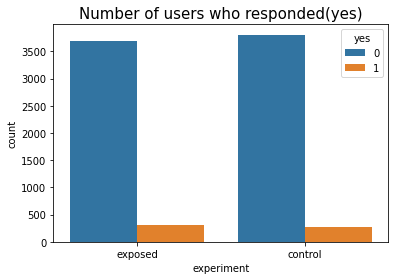

In [ ]:
sns.countplot(x='experiment',hue='yes',data=df)
plt.title('Number of users who responded(yes)',fontsize=15)

>> The number of users who responded 'yes' in both groups is quite low.

Text(0.5, 1.0, 'Number of users who responded(no)')

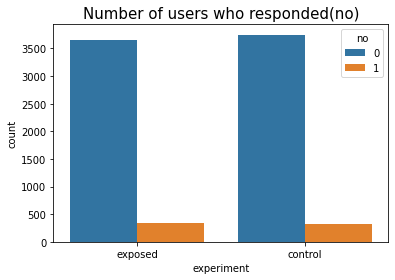

In [ ]:
sns.countplot(x='experiment',hue='no',data=df)
plt.title('Number of users who responded(no)',fontsize=15)

>> The number of users who responded 'no' in both groups is quite low.

**PLATFORM_OS**

Text(0.5, 1.0, 'Number of users using different Platform OS')

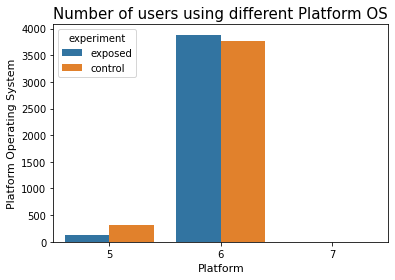

In [ ]:
sns.countplot(x='platform_os',hue='experiment',data=df)
plt.xlabel('Platform',fontsize=11)
plt.ylabel('Platform Operating System',fontsize=11)
plt.title('Number of users using different Platform OS',fontsize=15)

In [ ]:
df.platform_os.value_counts()

6    7648
5     428
7       1
Name: platform_os, dtype: int64

>> There are three different platform operating systems (5,6 and 7).Most of the people who engaged in this experiment were using Operating system platform 6.

**HOUR**

Text(0.5, 1.0, 'Distribution of users in different hours')

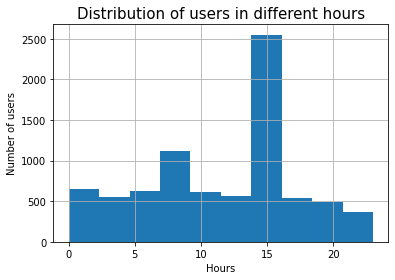

In [ ]:
df['hour'].hist()
plt.xlabel('Hours',fontsize=10)
plt.ylabel('Number of users',fontsize=10)
plt.title('Distribution of users in different hours',fontsize=15)

>> Most people are active around the 15th hour ie 3pm

**BROWSER**

In [ ]:
df.browser.value_counts()

Chrome Mobile                 4554
Chrome Mobile WebView         1489
Samsung Internet               824
Facebook                       764
Mobile Safari                  337
Chrome Mobile iOS               51
Mobile Safari UI/WKWebView      44
Chrome                           3
Pinterest                        3
Opera Mobile                     3
Android                          1
Puffin                           1
Firefox Mobile                   1
Edge Mobile                      1
Opera Mini                       1
Name: browser, dtype: int64

Text(0.5, 1.0, 'Top Browsers for each group in expeiment')

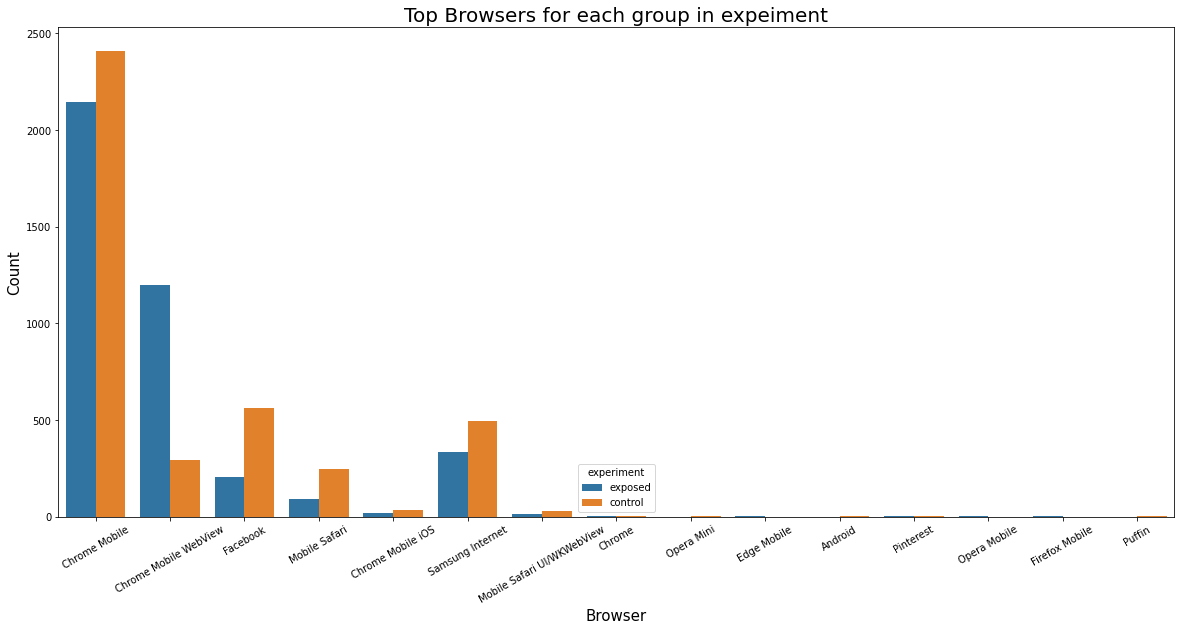

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 9))
sns.countplot(x='browser',hue='experiment',data=df)
plt.xticks(rotation=30)
plt.xlabel('Browser',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Top Browsers for each group in expeiment',fontsize=20)


Text(0.5, 1.0, 'Top Browsers used in experiment')

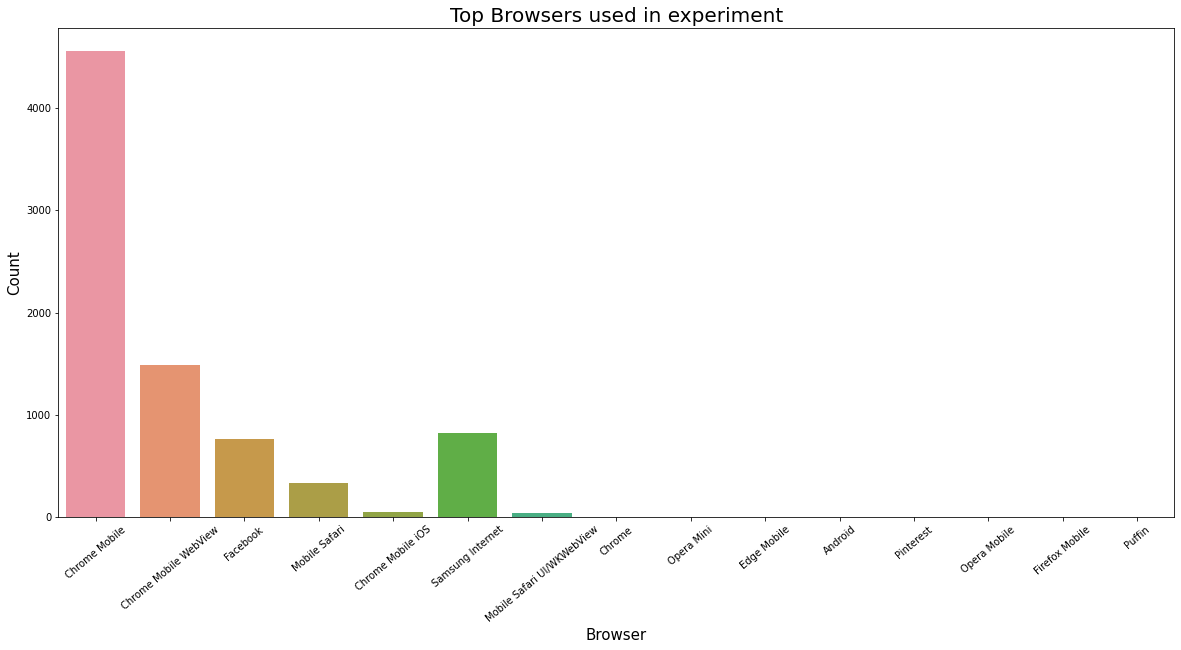

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 9))
sns.countplot(df['browser'])
plt.xticks(rotation=40)
plt.xlabel('Browser',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Top Browsers used in experiment',fontsize=20)

>> Top three used browsers are Chrome Browser,Chrom Mobile Webview and others responded via Facebook(supposing the questionnaire was posted there).Therefore Facebook is a good medium to promote brands.

**DEVICE_MAKE**

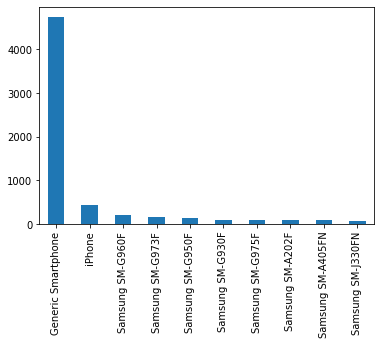

In [ ]:
df.device_make.value_counts().head(10).plot(kind='bar')


>> The above plot shows different samsung device makes are distributed all over.Let's group them into the main brand for better visualization on the top main brands

In [ ]:
df.head(3)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1


In [ ]:
df.loc[df['device_make'].str.contains('Samsung'), 'device_make'] = 'Samsung'
df.loc[df['device_make'].str.contains('Huawei',case=False), 'device_make'] = 'Huawei'
df.loc[df['device_make'].str.contains('HTC'), 'device_make'] = 'HTC'
df.loc[df['device_make'].str.contains('OnePlus'), 'device_make'] = 'OnePlus'
df.loc[df['device_make'].str.contains('XiaoMi'), 'device_make'] = 'XiaoMi'
df.loc[df['device_make'].str.contains('Nokia'), 'device_make'] = 'Nokia'


Text(0.5, 0, 'Device Make')

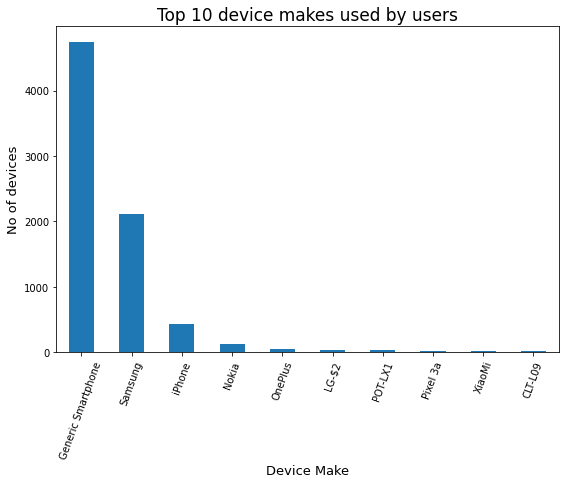

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9, 6))
df.device_make.value_counts().head(10).plot(kind='bar')
plt.title('Top 10 device makes used by users',fontsize=17)
plt.xticks(rotation=70,fontsize=10)
plt.ylabel('No of devices',fontsize=13)
plt.xlabel('Device Make',fontsize=13)

>> Top device makes for users who participated in experiment is General Smartphone,Samsung,Iphone,Nokia and OnePlus

Text(0.5, 0, 'Device Make')

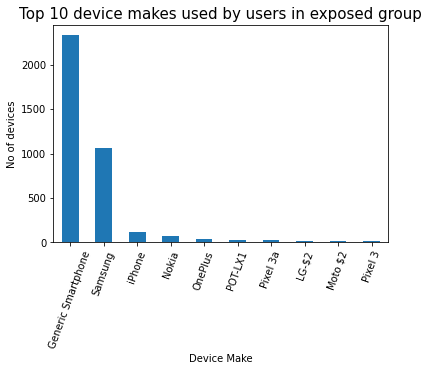

In [ ]:
exposed.device_make.value_counts().head(10).plot(kind='bar')
plt.title('Top 10 device makes used by users in exposed group',fontsize=15)
plt.xticks(rotation=70,fontsize=10)
plt.ylabel('No of devices',fontsize=10)
plt.xlabel('Device Make')

Text(0.5, 0, 'Device Make')

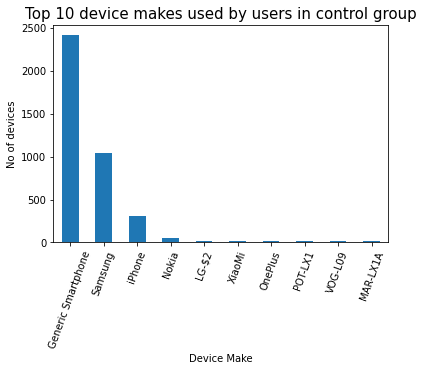

In [ ]:
control.device_make.value_counts().head(10).plot(kind='bar')
plt.title('Top 10 device makes used by users in control group',fontsize=15)
plt.xticks(rotation=70,fontsize=10)
plt.ylabel('No of devices',fontsize=10)
plt.xlabel('Device Make')

>> The same top device makes are observed across both groups

**DATE**


In [ ]:

df1=df.groupby('date')['auction_id'].count().reset_index()
df1

,date,auction_id
0,2020-07-03,2015
1,2020-07-04,903
2,2020-07-05,890
3,2020-07-06,490
4,2020-07-07,480
5,2020-07-08,1198
6,2020-07-09,1208
7,2020-07-10,893


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

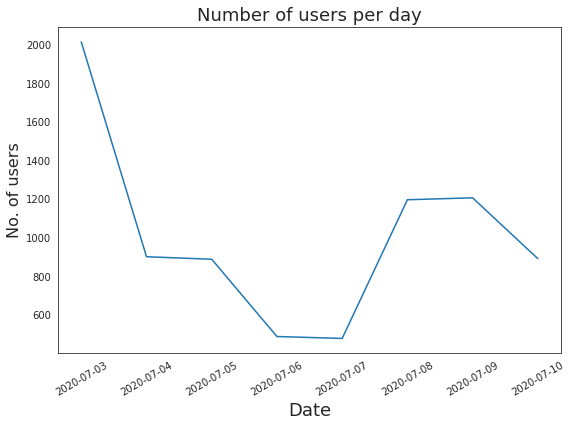

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9, 6))
sns.lineplot(x="date", y="auction_id",data=df1)
plt.title("Number of users per day",fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('No. of users',fontsize=16)
plt.xticks(rotation=30)

>> The number of users are highest on Friday(2020-07-03) then reduce during the weekend and start of the week,then it increases again.

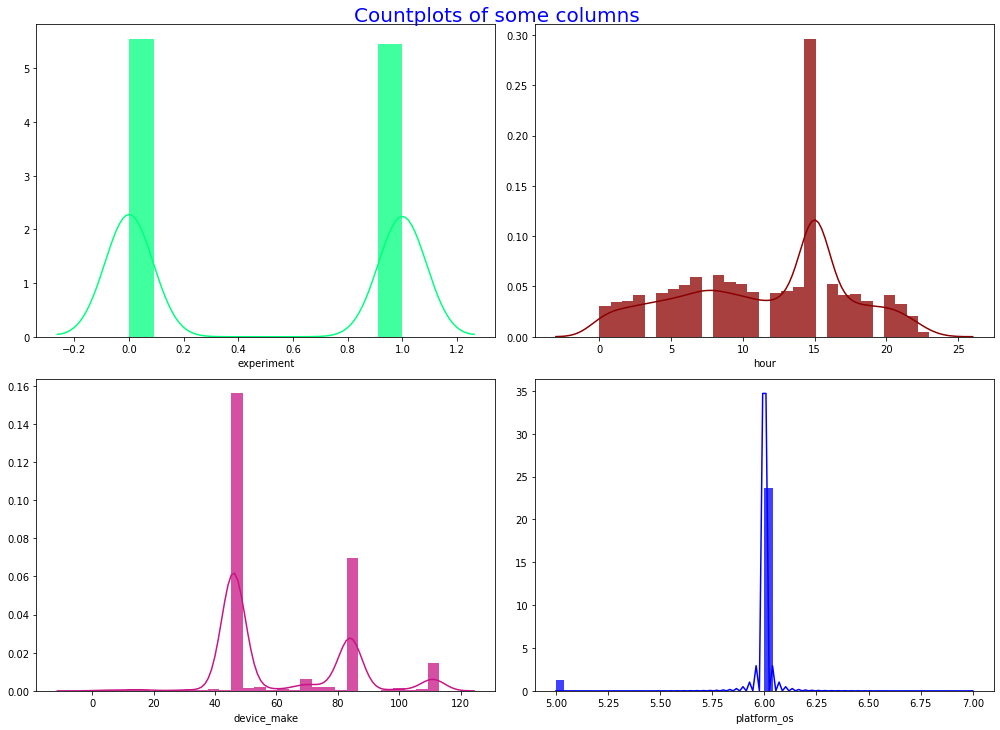

In [ ]:
# plotting the histograms of some of our numerical variables with the



fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))
plt.suptitle('Countplots of some columns ', fontsize = 20, y = 1.01, color = 'blue')

colors = ['#00FF7F', '#8B0000', '#C71585', '#0000FF', '#DB7093', '#FFFF00', '#FF4500',
          '#7B68EE', '#FF00FF', '#ADFF2F', '#FFD700', '#A52A2A', '#2F4F4F', '#8B008B']
for ax, column, color in zip(axes.flatten(), data, colors):
    sns.distplot(data[column], ax = ax, color = color, hist_kws = dict(alpha = 0.75))
    
plt.tight_layout()

#### Summary of number of responses(yes and no) in each group of the experiment

In [ ]:
df.experiment.value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

>>The control had 4071 users while exposed had 4006 users

In [ ]:
control=df[df['experiment']=='control']
control.tail(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
8069,ffca1153-c182-4f32-9e90-2a6008417497,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0,1
8070,ffcea781-a6e7-4f98-9d90-f95377270476,control,2020-07-03,15,Samsung,6,Facebook,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8076,fffbb9ff-568a-41a5-a0c3-6866592f80d8,control,2020-07-10,14,Samsung,6,Facebook,0,0


In [ ]:
exposed=df[df['experiment']=='exposed']
exposed.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
8,004940f5-c642-417a-8fd2-c8e5d989f358,exposed,2020-07-04,0,Generic Smartphone,6,Chrome Mobile WebView,0,0
13,006b9c6e-5f5d-4385-a811-ff20a24b30ac,exposed,2020-07-06,8,Samsung,6,Chrome Mobile WebView,0,0


In [ ]:
df_summary=df.pivot_table(values='yes',index='experiment',aggfunc=np.sum)

In [ ]:
df_summary['total']=df.pivot_table(values='yes',index='experiment',aggfunc=lambda x: len(x))

In [ ]:
df_summary['no']=df.pivot_table(values='no',index='experiment',aggfunc=np.sum)
df_summary

,yes,total,no
experiment,,,
control,264,4071,322
exposed,308,4006,349


>> * In control those who responded yes are 264/4071 and 308/4006 in exposed group
* In control those who responded no are 322/4071 and 349/4006 in exposed group

   * More users from exposed group are aware of the brand


## <font color='#2F4F4F'>A/B Testing</font>

### **Metric Choice**
For this experiment,we have two types of metrics
 * ***Invariate metrics***-used to make sure our experiement (the way we presented a change to a part of the poupaltion)is not inherently wrong.We pick metrics which we consider not to change(or get affected) because of the expt. and make sure they dont change drastically between the exposed and experiment group.
 eg click through probability,number of users in each group
 * **Evaluation metrics**-These are metrics that we expect to see a change,and are relevant to the business goals we aim to achieve eg. conversion(brand awareness) rate


**Invariance metrics sanity checks** help verify that the experiment was conducted as expected and that other factors did not influence the data collected eg
 * Number of users in the experiement
 * Number of clicks/responses in the experiment
 * Click through probability

We'll check whether these observed values are like we expect(if in fact the experiement was not damaged)


In [ ]:
def get_z_score(alpha):
    return norm.ppf(alpha)

#### Difference in number of users who viewed the experiment
* We expect the number of users  in the control group to be about a half (50%) of the total users in both groups, so we can define a random variable with an easy to use distribution.
* A binomial random variable will be the number of successes we can expect to get out of N experiments, given the probability of a single success. So, if we consider being assigned to a group (control, for example) a success with probability 0.5 (random!), the number of samples which get assigned to the group is the value of our random binomial variable!

* This get's easier thanks to the central limit theorem which let's us approximate the binomial distribution to a normal distribution (when n is large enough) with a mean of  p  and a standard deviation    sqrt(p(1−p)/N)
X ~ N(p,sqrt(p/(1−p)N)) 
* What we want to test is whether our observed  p^  (number of samples in control divided by total number of samples in both groups) is not significantly different than  p=0.5 . In order to do that we can calculate the margin of error acceptable at a 95% confidence level:
ME=Z1−α/2*SD 
* Finally, a confidence interval can be derived to tell us in which range an observed  p  can exist and be acceptable as "the same" as the expected value.


CI=[p^−ME,p^+ME] 
When our obsereved  p^  is within this range, all is well and the test was passed.

In [ ]:
##Number of users who viewed the experiment

import math as mt 

experiment_total=exposed_total+control_total
p=0.5
alpha=0.05
p_hat=round(control_total/(experiment_total),4)
sd=mt.sqrt(p*(1-p)/(experiment_total))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0.4891 and 0.5109 ; Is 0.504 inside this range?


>> Our observed  p-hat  is inside this range which means the difference in number of samples between groups is expected. So far so good, since this invariant metric sanity test passes!

#### Difference in sample size is the same for both groups using SPRT
* Just doing the same as above using sequential probability ratio test

 * **H0**(*Null hypothesis*):No difference in response is the same for both groups
 * **H1**(*Alternative hypothesis*):No difference in response is the same for both groups 

In [ ]:
!pip install sprt

In [ ]:


import sprt as sprt
import numpy as np
# SPRT 
# Binomial Endpoints
import sprt as sprt
import numpy as np


# Type I error rate = 0.05
alpha = 0.05
# Type II error rate = 0.2
beta = 0.2
# Values
values = control['yes'].values
test = sprt.SPRTBinomial(h0 = h0, h1 = h1, alpha = alpha, beta = beta, values = values)

Decision:	Accept

      values    lower    upper
n                             
4062     264  301.349  323.189
4063     264  301.426  323.265
4064     264  301.502  323.342
4065     264  301.578  323.418
4066     264  301.654  323.494
4067     264  301.730  323.570
4068     264  301.806  323.646
4069     264  301.882  323.722
4070     264  301.958  323.798
4071     264  302.035  323.874


In [ ]:
control=df[df['experiment']=='control']
exposed=df[df['experiment']=='exposed']

In [ ]:
control.yes.value_counts()

0    3807
1     264
Name: yes, dtype: int64

In [ ]:
h0=264/3807
h0

0.06934594168636722

In [ ]:
exposed.yes.value_counts()


0    3698
1     308
Name: yes, dtype: int64

In [ ]:
h1=308/3698
h1

0.08328826392644673

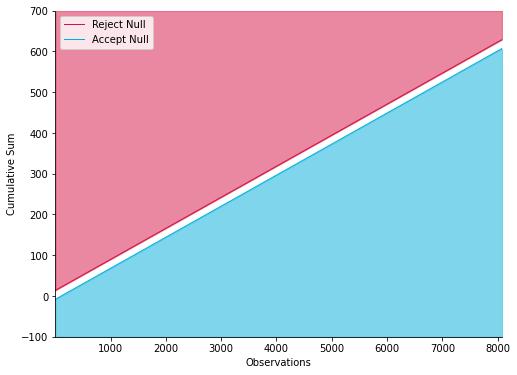

In [ ]:
test.plotBoundary()

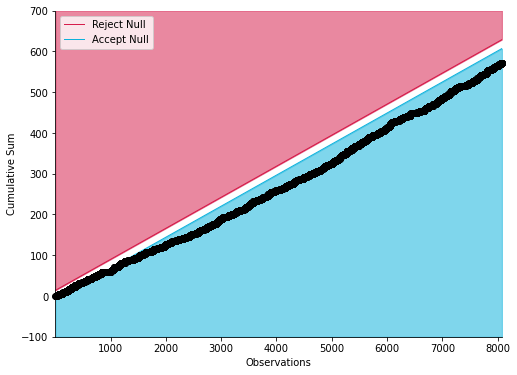

In [ ]:
test.plot()

>> Accept the null hypothesis that there is no difference between the two groups.


In [ ]:
##Number of users who responded
control_responses=control['yes'].sum()+control['no'].sum()
exposed_responses=exposed['yes'].sum()+exposed['no'].sum()

response_total=control_responses +exposed_responses


p_hat=round(control_responses/(response_total),4)
sd=mt.sqrt(p*(1-p)/(response_total))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")


The confidence interval is between 0.4722 and 0.5278 ; Is 0.4714 inside this range?


#### Difference in number of users who responded

* In this case, we want to make sure the proportion of responses given the questionnaire (our observed CTP) is about the same in both groups (since this was not expected to change due to the experiment). In order to check this out we will calculate the CTP in each group and calculate a confidence interval for the expected difference between them.
* In other words, we expect to see no difference ( CTPexp−CTPcont=0 ), with an acceptable margin of error, dictated by our calculated confidence interval. The changes we should notice are for the calculation of the standard error - which in this case is a pooled standard error.

SDpool=sqrt(ppool^(1−ppool^(1Ncont+1Nexp))
with
ppool^=((xcont+xexp)/(Ncont+Nexp)) 
* We should understand that CTP is a proportion in a population (amount of events x in a population n) like the amount of responses out of the amount of users given questionnaire.

In [ ]:
##Click through probability
ctp_control=control_responses/4071
ctp_exposed=exposed_responses/4006

d_hat=round(ctp_exposed-ctp_control,4)

p_pooled=response_total/8077
sd_pooled=mt.sqrt(p_pooled*(1-p_pooled)*(1/4071 + 1/4006))

ME=round(get_z_score(1-(alpha/2)) **sd_pooled,4)
print ("The confidence interval is between",0-ME,"and",0+ME,"; Is",d_hat,"within this range?")

The confidence interval is between -1.0054 and 1.0054 ; Is 0.0201 within this range?


#### Difference in platforms between the groups.
**Null Hypothesis:** The number of users for the platform_os used is different for exposed and control group.

**Alternative Hypthosis:** The number of users for the platform_os used is not different for exposed and control group.

In [ ]:
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats

In [ ]:
sm.stats.ztest(exposed['platform_os'], control['platform_os'],alternative='two-sided')


(9.252358074412673, 2.195936596838038e-20)

>> Since the p-value  (2.195936596838038e-20) is extremely small, we can reject the Null hypothesis that the number of users for the plaform is statistically significantly different

#### Difference in hours distribution between the group
**Null Hypothesis:** The distribution of user's hours  is different for exposed and control group.

**Alternative Hypthosis:**   The distribution of user's hours used is not different for exposed and control group.

In [ ]:
sm.stats.ztest(exposed['hour'], control['hour'],alternative='two-sided')

(-14.13708503652261, 2.2438815524848284e-45)

>> Since the p-value  (2.2438815524848284e-45)) is extremely small, we can reject the Null hypothesis that the distribution of user's hours is  statistically significantly different for exposed and control group.

#### Sample Size for the Conversion(Brand awareness) rate

In [ ]:
def get_sds(p,d):
    sd1=mt.sqrt(2*p*(1-p))
    sd2=mt.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    x=[sd1,sd2]
    return x
#Inputs: required alpha value (alpha should already fit the required test)
#Returns: z-score for given alpha
def get_z_score(alpha):
    return norm.ppf(alpha)

# Inputs p-baseline conversion rate which is our estimated p and d-minimum detectable change
# Returns
def get_sds(p,d):
    sd1=mt.sqrt(2*p*(1-p))
    sd2=mt.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    sds=[sd1,sd2]
    return sds

# Inputs:sd1-sd for the baseline,sd2-sd for the expected change,alpha,beta,d-d_min,p-baseline estimate p
# Returns: the minimum sample size required per group according to metric denominator
def get_sampSize(sds,alpha,beta,d):
    n=pow((get_z_score(1-alpha/2)*sds[0]+get_z_score(1-beta)*sds[1]),2)/pow(d,2)
    return n

In [ ]:
p_hat=((control_converted+exposed_converted)/(control_total+exposed_total))
d=0.01

In [ ]:
import math as mt
sample_size=round(get_sampSize(get_sds(p_hat,d),0.05,0.2,d))
sample_size

10527.0

>> The required effective sample size should be 10527, which is less than the sampple we have.We can consider using sequential testing to deal with this limitation.

### How many users from each group were aware of the brand.(awarenes rate)

In [ ]:
exposed=df[df['experiment']=='exposed']
exposed.tail(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
8065,ffbc02cb-628a-4de5-87fc-5d76b7d796e5,exposed,2020-07-09,17,Generic Smartphone,6,Chrome Mobile,0,0
8067,ffc594ef-756c-4d24-a310-0d8eb4e11eb7,exposed,2020-07-05,1,Samsung SM-G950F,6,Chrome Mobile WebView,0,0
8071,ffdfdc09-48c7-4bfb-80f8-ec1eb633602b,exposed,2020-07-03,4,Generic Smartphone,6,Chrome Mobile,0,1
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [ ]:
control=df[df['experiment']=='control']
control.tail(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
8069,ffca1153-c182-4f32-9e90-2a6008417497,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0,1
8070,ffcea781-a6e7-4f98-9d90-f95377270476,control,2020-07-03,15,Samsung SM-N976B,6,Facebook,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8076,fffbb9ff-568a-41a5-a0c3-6866592f80d8,control,2020-07-10,14,Samsung SM-G960F,6,Facebook,0,0


In [ ]:
control['yes'].value_counts()

0    3807
1     264
Name: yes, dtype: int64

In [ ]:
control['no'].value_counts()

0    3749
1     322
Name: no, dtype: int64

In [ ]:
control_converted,exposed_converted=control['yes'].sum(),exposed['yes'].sum()
control_converted,exposed_converted

(264, 308)

In [ ]:
control_total,exposed_total=len(control),len(exposed)
control_total,exposed_total

(4071, 4006)

In [ ]:
p_control, p_exposed =control_converted / control_total, exposed_converted / exposed_total
p_control, p_exposed

(0.06484893146647015, 0.07688467299051423)

In [ ]:
p_exposed-p_control

0.012035741524044075

In [ ]:
df_summary['rate']=df.pivot_table(values='yes',index='experiment')
df_summary

,yes,total,no,rate
experiment,,,,
control,264,4071,322,0.064849
exposed,308,4006,349,0.076885


>> The rate of brand awareness in the control group is 0.064849 while in the exposed it is 0.076885.There's an increase of 0.01204 after the experiment in the exposed group.

>> The next step is looking at the changes between the control and experiment groups with regard to our evaluation metrics to make sure the difference is there, that it is statistically significant and most importantly practically significant (the difference is "big" enough to make the experimented change beneficial to the company).

### Hypothesis for A/B testing



  - **Null Hypothesis** :There is no difference in brand awareness between the exposed and control groups in the current case.
   
  - **Alternative Hypothesis**:There is a difference in brand awareness between the exposed and control groups in the current case.

We can work with binomial distribution or we can invoke the Central limit Theorem.As we are interested in the average conversion,this averaging of an underlying distribution means our final estimate will be well approxiamted by a normal distribution.
 So we reformulate using normal approximation

Text(0, 0.5, 'Probability')

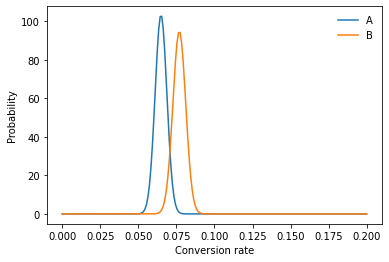

In [ ]:
from scipy.stats import norm


std_control = np.sqrt(p_control * (1 - p_control) /control_total )
std_exposed = np.sqrt(p_exposed * (1 - p_exposed) / exposed_total)

click_rate = np.linspace(0, 0.2, 200)
prob_a = norm(p_control, std_control).pdf(click_rate)
prob_b = norm(p_exposed, std_exposed).pdf(click_rate)

# Make the bar plots.
plt.plot(click_rate, prob_a, label="A")
plt.plot(click_rate, prob_b, label="B")
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability")

zscore is 2.108, with p-value 0.018


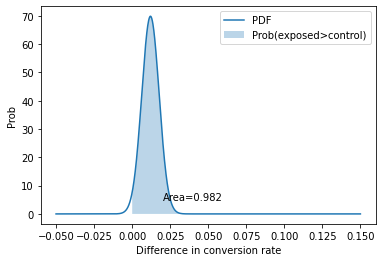

In [ ]:
z_score=(p_exposed-p_control)/np.sqrt(std_control**2+std_exposed**2)
p=norm(p_exposed-p_control,np.sqrt(std_control**2+ std_exposed**2))

x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(exposed>control)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")



Given the null hypothesis is true (There is no difference in brand awareness between the exposed and control groups in the current case.), we would expect to get this result or a result more extreme only 1.8% of the time. As that is an insignificant result (typically p < 5%), we reject the null hypothesis, and state that we have evidence that There is no difference in brand awareness between the exposed and control groups in the current case.A p-value less than 0.05 (typically ≤ 0.05) is statistically significant. It indicates strong evidence against the null hypothesis, as there is less than a 5% probability the null is correct (and the results are random). Therefore, we reject the null hypothesis, and accept the alternative hypothesis.

>> From above we can conclude that there  is a statistically significant difference in brand awareness between the exposed and control groups in the current case.
We saw an increase in brand awareness between the control and exposed groups

## <font color='#2F4F4F'>Machine Learning</font>

We will carry out 3 types of classification analysis, namely:
1. Logistic Regression
2. Decison Trees italicised text
3. XGboost

We will then compare the different classification models to assess the best performing one(s).

In [ ]:
df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [ ]:
data=df.copy()

### 3.3 Feature Engineering & Test for Multicollinearity
* Before we can carry out the test for multicollinearity (a requirement for logistic regression), we need to convert some categorical values to numeric values and restructure some features.

We will drop the auction id column since it just represnts randomly assigned numbers

In [ ]:
data.drop('auction_id',axis=1,inplace=True)

For the target variable,we will have a column representing the response of the user i.e  yes or no.So we will drop those who didn't respond

In [ ]:
data=data[~(data[['yes','no']] == 0).all(axis=1)]
data.sample(3)

,experiment,date,hour,device_make,platform_os,browser,yes,no
6871,exposed,2020-07-09,11,Generic Smartphone,6,Chrome Mobile,0,1
3730,exposed,2020-07-03,13,Generic Smartphone,6,Chrome Mobile,1,0
7654,exposed,2020-07-09,21,Generic Smartphone,6,Chrome Mobile WebView,1,0


In [ ]:
data['response']=np.where(data['yes']==1,1,0)
data.drop('yes',axis=1,inplace=True)
data.drop('no',axis=1,inplace=True)
data.sample(8)

,experiment,date,hour,device_make,platform_os,browser,response
4598,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1
6215,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0
5322,control,2020-07-10,11,Generic Smartphone,6,Chrome Mobile,0
3957,control,2020-07-06,1,MAR-LX1A,6,Facebook,0
4583,control,2020-07-03,15,Samsung,6,Chrome Mobile WebView,0
8054,exposed,2020-07-10,8,Samsung,6,Samsung Internet,1
1097,exposed,2020-07-03,8,iPhone,5,Mobile Safari,0
2239,exposed,2020-07-04,2,Generic Smartphone,6,Chrome Mobile WebView,0


We now need to deal with the categorical variables..experiment,device_make and browser

In [ ]:
experiment={'experiment':
            {'exposed':1,'control':0}
            }
data.replace(experiment,inplace=True)
data['experiment'].head(5)


2     1
16    1
20    1
23    0
27    0
Name: experiment, dtype: int64

In [ ]:
data=pd.get_dummies(data,columns=['browser'])

In [ ]:
data.head(3)

,experiment,date,hour,device_make,platform_os,response,browser_Chrome,browser_Chrome Mobile,browser_Chrome Mobile WebView,browser_Chrome Mobile iOS,browser_Facebook,browser_Mobile Safari,browser_Mobile Safari UI/WKWebView,browser_Samsung Internet
2,1,2020-07-05,2,E5823,6,0,0,0,1,0,0,0,0,0
16,1,2020-07-04,16,Generic Smartphone,6,1,0,1,0,0,0,0,0,0
20,1,2020-07-06,8,Generic Smartphone,6,0,0,1,0,0,0,0,0,0


In [ ]:
data.device_make.value_counts()
searchfor=['Generic Smartphone','Samsung','iPhone','LG-$2','HTC','POT-LX1','Nokia','OnePlus','Pixel 3a','XiaoMi','CLT-L09' ]

data.loc[~(data['device_make'].astype(str).str.contains('|'.join(searchfor))), 'device_make'] = 'Others'

In [ ]:
data['device_make'].value_counts().head(40)

Generic Smartphone    719
Samsung               367
Others                 89
Nokia                  20
iPhone                 18
POT-LX1                 8
XiaoMi                  6
OnePlus                 5
CLT-L09                 5
HTC                     4
Pixel 3a                2
Name: device_make, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["device_make"] = label_encoder.fit_transform(data["device_make"])
data.head(5)

,experiment,date,hour,device_make,platform_os,response,browser_Chrome,browser_Chrome Mobile,browser_Chrome Mobile WebView,browser_Chrome Mobile iOS,browser_Facebook,browser_Mobile Safari,browser_Mobile Safari UI/WKWebView,browser_Samsung Internet
2,1,2020-07-05,2,5,6,0,0,0,1,0,0,0,0,0
16,1,2020-07-04,16,1,6,1,0,1,0,0,0,0,0,0
20,1,2020-07-06,8,1,6,0,0,1,0,0,0,0,0,0
23,0,2020-07-08,4,8,6,1,0,0,0,0,1,0,0,0
27,0,2020-07-03,15,1,6,0,0,1,0,0,0,0,0,0


In [ ]:
data.head(5)
data.drop('date',axis=1,inplace=True)

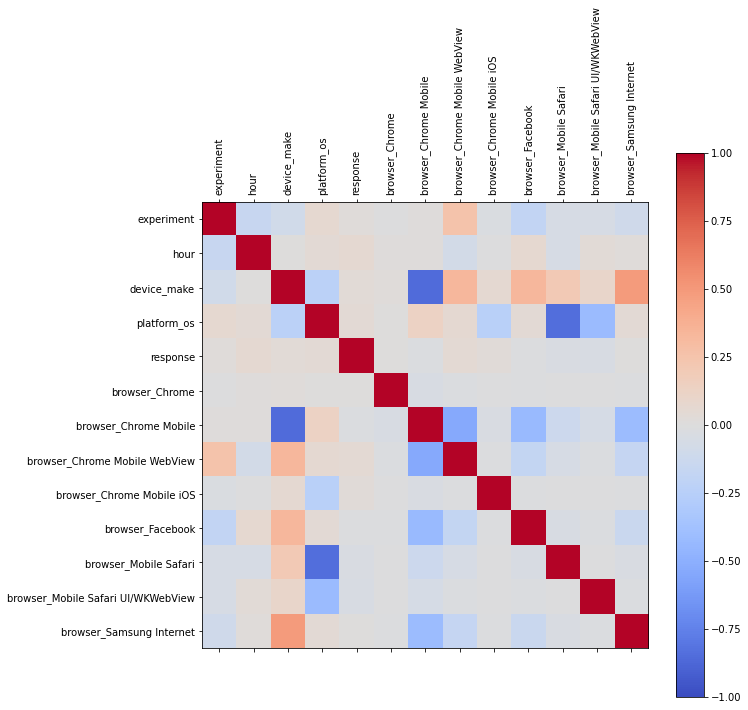

In [ ]:
# checking the correlations between the numerical variables

corr = data.corr()

# plotting the correlations onto a heatmap
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

### Splitting data 
* We split the data into 70% training, 20% validation and 10% test


In [ ]:
# dividing our dataset into features (X) and target (y)
y = data.iloc[:,-1].values  # Independent/predictor variables
X = data.iloc[:, :-1].values


from sklearn.model_selection import train_test_split

x, x_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.7,random_state = 0)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.22,train_size =0.78,random_state = 0)

In [ ]:
# performing feature scaling on our training data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# fitting and transforming X_train while transforming X_test
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_cv = scaler.transform(x_cv)

###Apply ML and train using 5-fold CV
* Train a machine learning model using 5-fold cross validation the following 3 different algorithms:
 * Logistic Regression 
 * Decision Trees
 * XGBoost



In [ ]:
# 5-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

logreg = LogisticRegression()

print(cross_val_score(logreg, x_train, y_train, cv=5, scoring='accuracy').mean())

scores=cross_val_score(logreg, x_train, y_train, cv=5, scoring='accuracy')
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

0.9985185185185186
Scores: [1.         1.         1.         1.         0.99259259]
Mean: 0.9985185185185186
Standard Deviation: 0.002962962962962967


In [ ]:
# 5-fold cross-validation with XGbooost
from xgboost import XGBClassifier

xgb_cv = XGBClassifier(n_estimators=100)

print(cross_val_score(xgb_cv, x_train, y_train, cv=5, scoring = "accuracy").mean())

scores = cross_val_score(xgb_cv, x_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

1.0
Scores: [1. 1. 1. 1. 1.]
Mean: 1.0
Standard Deviation: 0.0


In [ ]:
# 5-fold cross-validation with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

print(cross_val_score(decision_tree, x_train, y_train, cv=5, scoring='accuracy').mean())

scores = cross_val_score(decision_tree, x_train, y_train, cv=5, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

0.9985185185185186
Scores: [1. 1. 1. 1. 1.]
Mean: 1.0
Standard Deviation: 0.0


### Loss Function

In [ ]:
from sklearn.metrics import log_loss
# classification report for Logistic Regression
print("Logistic Regression classification report:")
print(log_loss(y_test, logistic_y_prediction))


# classification report for Decision Tree Classifier
print("Decision Tree classification report:")
print(log_loss(y_test, decision_y_prediction))

# classification report for Decision Tree Classifier
print("XGBoost report:")
print(log_loss(y_test, xgb_y_prediction))

Logistic Regression classification report:


ValueError: ignored

In [ ]:
logreg.fit(x_cv, y_cv)
decision_tree.fit(x_cv, y_cv)
xgb_cv.fit(x_cv, y_cv)


# making predictions
logistic_y_prediction = logreg.predict(x_test) 
decision_y_prediction = decision_tree.predict(x_test) 
xgb_y_prediction = xgb_cv.predict(x_test) 


In [ ]:
# printing the classification report for each classifier to assess performance
from sklearn.metrics import classification_report

# classification report for Logistic Regression
print("Logistic Regression classification report:")
print(classification_report(y_test, logistic_y_prediction))


# classification report for Decision Tree Classifier
print("Decision Tree classification report:")
print(classification_report(y_test, decision_y_prediction))

# classification report for Decision Tree Classifier
print("XGBoost report:")
print(classification_report(y_test, xgb_y_prediction))



Logistic Regression classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       0.95      1.00      0.98        21

    accuracy                           1.00       249
   macro avg       0.98      1.00      0.99       249
weighted avg       1.00      1.00      1.00       249

Decision Tree classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      1.00      1.00        21

    accuracy                           1.00       249
   macro avg       1.00      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249

XGBoost report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       228
           1       0.83      0.71      0.77        21

    accuracy                           0.96       249
   macro avg       0.90      0.8

In [ ]:
from sklearn.metrics import confusion_matrix 
 
print('Logistic Regression classifier:')
print(confusion_matrix(logistic_y_prediction, y_test))

print('Decision Tree classifier:')
print(confusion_matrix(decision_y_prediction, y_test))

print('XGBoost :')
print(confusion_matrix(xgb_y_prediction, y_test))


### Feature Importance

* Provide insights into the dataset.The relative scores can highlight which features may be most relevant to the target, and the converse, which features are the least relevant.
* Provide insight into the dataset.Most importance scores are calculated by a predictive model that has been fit on the dataset. Inspecting the importance score provides insight into that specific model and which features are the most important and least important to the model when making a prediction
* Improve a predictive model.his can be achieved by using the importance scores to select those features to delete (lowest scores) or those features to keep (highest scores).
---



#### Logistic regression feature importance

In [ ]:
# get importance logistic
from matplotlib import pyplot

x=data.drop('response',axis=1).columns

logreg.fit(x_train,y_train)
importance = logreg.coef_[0]
# summarize feature importance
for x,v in zip(x,importance):
	print('Feature: %s, Score: %.5f' % (x,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
importances

>> The following are important parameters for gaining more 'Yes' results:
* platform_os
* browser_Facebook
* experiment
* device make


In [ ]:
importances = pd.DataFrame({
    'Feature': data.drop('response', axis=1).columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances.plot(kind='bar')

Recall this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

#### XGBoost Feature Importance

In [ ]:
xgb_cv.fit(x_train,y_train)
importances = pd.DataFrame({
    'Feature': data.drop('response', axis=1).columns,
    'Importance': xgb_cv.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

>> The following are important features for the XGBoost model:
* device_make
* browser(Facebook,Samsung Internet,Chrome Mobile)
* experiment

In [ ]:
importances.plot(kind='bar')

#### Decision Tree Feature Importance

In [ ]:
# get importance for decision

x=data.drop('response',axis=1).columns

decision_tree.fit(x_train,y_train)
importance = decision_tree.feature_importances_
# summarize feature importance
for x,v in zip(x,importance):
	print('Feature: %s , Score: %.5f' % (x,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
importances

>> The following are important features for the Decision tree model:
* hour
* device_make
* browser(Samsung Internet,Chrome Mobile view)
* experiment

In [ ]:
decision_tree.fit(x_train,y_train)
importances = pd.DataFrame({
    'Feature': data.drop('response', axis=1).columns,
    'Importance': decision_tree.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances.plot(kind='bar')

## <font color='#2F4F4F'>Summary of Findings</font>


### **Best Model**

### **Data features relevant for predicting target variable**
* From the three models the top 5 features with the highest importance are:
 * Device_make
 * Browser(Samsung,Facebook,Chrome Mobile view)
 * Hour
 * platform_os
 * experiment

  -Those using the above device_make,browser,platform_os at specified hours and belonging to a specific group contibute to target variable(yes ie. aware of brand)

### **Difference between A/B testing and using Machine learning**
* A/B testing is used to determine whether there's a significant difference between the two different groups for the control and exposed group.It helps us check whether the experiment carried out has any efect.
* Machine learning   analysis provides the insight regarding the high or no significance of the experimental feature after fitting/predicting, you can obtain the feature importance to determine the best parameters for predicting the target variable.

### **Purpose of training using k-fold cross validation**
* Cross-validation is primarily used in to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.
* Results in less biased or less optimistic estimate of the model skill than other methods.
* A model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting

### **Information gained using ML approach that couldn't be obtained using A/B testing**
* Feature Importance-ML helps us determine the best parameters  that lead a user to respond (yes) to awareness of brand. i.e predicting the target variable.This helps us determine the best metrics to rely on if we want to improve brand awareness.
* While A/B testing,helps us determine if the change due to the experiement is statistically significantly different but doesn't provide further insights on how to improve the brand awareness.

## <font color='#2F4F4F'>Recommendations</font>

* From the analysis,the  creative,  online interactive 
ad has more effect than the dummy ad hence should be implemented for better brand awareness.
*Furthermore,from the hour variable distribution,users mostly engaged at 1500 hrs  .Therefore most ads can be streamed during that period.Also there was high engagement on Friday(assuming this is the case for subsequent days ,as we only had one week) more effort in advertising should be emphasized during this day of the week.
* We also noticed that most users responded through Facebook,consequently,advertisement in this platform should be considered and enhanced.
